<a href="https://colab.research.google.com/github/mkeohane01/GAN-Image-Denoising/blob/main/notebooks/train-GAN-denoise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load Data

In [1]:
!pip install kaggle
from google.colab import files
files.upload()

# Download kaggle dataset
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Small SIDD dataset
!kaggle datasets download -d rajat95gupta/smartphone-image-denoising-dataset

# Blurred Image Pairs
!kaggle datasets download -d kwentar/blur-dataset

# Medium dataset
#!kaggle datasets download -d soumikrakshit/smartphone-image-denoising-dataset

Saving kaggle.json to kaggle.json
100% 6.16G/6.16G [05:21<00:00, 11.6MB/s]
100% 6.16G/6.16G [05:21<00:00, 20.6MB/s]
100% 1.49G/1.49G [01:20<00:00, 20.0MB/s]
100% 1.49G/1.49G [01:20<00:00, 19.8MB/s]


In [2]:
# Unzip the smartphone denoising dataset
!unzip '/content/smartphone-image-denoising-dataset.zip'

!unzip '/content/blur-dataset.zip'

Archive:  /content/smartphone-image-denoising-dataset.zip
  inflating: SIDD_Small_sRGB_Only/Data/0001_001_S6_00100_00060_3200_L/GT_SRGB_010.PNG  
  inflating: SIDD_Small_sRGB_Only/Data/0001_001_S6_00100_00060_3200_L/NOISY_SRGB_010.PNG  
  inflating: SIDD_Small_sRGB_Only/Data/0002_001_S6_00100_00020_3200_N/GT_SRGB_010.PNG  
  inflating: SIDD_Small_sRGB_Only/Data/0002_001_S6_00100_00020_3200_N/NOISY_SRGB_010.PNG  
  inflating: SIDD_Small_sRGB_Only/Data/0003_001_S6_00100_00060_3200_H/GT_SRGB_010.PNG  
  inflating: SIDD_Small_sRGB_Only/Data/0003_001_S6_00100_00060_3200_H/NOISY_SRGB_010.PNG  
  inflating: SIDD_Small_sRGB_Only/Data/0004_001_S6_00100_00060_4400_L/GT_SRGB_010.PNG  
  inflating: SIDD_Small_sRGB_Only/Data/0004_001_S6_00100_00060_4400_L/NOISY_SRGB_010.PNG  
  inflating: SIDD_Small_sRGB_Only/Data/0005_001_S6_00100_00060_4400_N/GT_SRGB_010.PNG  
  inflating: SIDD_Small_sRGB_Only/Data/0005_001_S6_00100_00060_4400_N/NOISY_SRGB_010.PNG  
  inflating: SIDD_Small_sRGB_Only/Data/0006_001

## Imports

In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor
from PIL import Image
from sklearn.model_selection import train_test_split
from torchvision import transforms as T
from skimage.metrics import structural_similarity as ssim
import numpy as np
import cv2
from math import log10, sqrt
import matplotlib.pyplot as plt
import random
from scipy.linalg import sqrtm

## Define Model

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # Encoder layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1)
        self.conv5 = nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1)

        # Decoder layers
        self.deconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1)
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.deconv5 = nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1)

        # Batch normalization layers
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn4 = nn.BatchNorm2d(512)
        self.bn5 = nn.BatchNorm2d(1024)

    def forward(self, x):
        # Encoder
        x1 = F.leaky_relu(self.bn1(self.conv1(x)), 0.2)
        x2 = F.leaky_relu(self.bn2(self.conv2(x1)), 0.2)
        x3 = F.leaky_relu(self.bn3(self.conv3(x2)), 0.2)
        x4 = F.leaky_relu(self.bn4(self.conv4(x3)), 0.2)
        x5 = F.leaky_relu(self.bn5(self.conv5(x4)), 0.2)

        # Decoder with skip connections
        d1 = F.relu(self.deconv1(x5))
        d2 = F.relu(self.deconv2(d1 + x4))  #  skip connections
        d3 = F.relu(self.deconv3(d2 + x3))
        d4 = F.relu(self.deconv4(d3 + x2))
        d5 = self.deconv5(d4 + x1)

        # Output
        output = torch.tanh(d5)  # tanh activation - range is [-1, 1]
        return output

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # Initial convolution layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1)

        # Downscaling convolution layers
        self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1)
        self.conv5 = nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1)  # Added layer

        # Batch normalization layers
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn4 = nn.BatchNorm2d(512)
        self.bn5 = nn.BatchNorm2d(1024)  # Added bn

        # Final convolution layer that outputs a single value for classification - adjusted for 512x512 images
        self.conv6 = nn.Conv2d(1024, 1, kernel_size=4, stride=1, padding=0)  # Adjusted layer

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.bn2(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.bn3(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.bn4(self.conv4(x)), 0.2)
        x = F.leaky_relu(self.bn5(self.conv5(x)), 0.2)  # Added layer

        # Flatten the output to a single value
        x = self.conv6(x)
        x = torch.flatten(x, 1)
        x = torch.sigmoid(x)  # Sigmoid activation to get a value between 0 and 1

        return x

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        # Apply Kaiming He initialization
        nn.init.kaiming_normal_(m.weight.data, nonlinearity='leaky_relu' if isinstance(m, nn.LeakyReLU) else 'relu')
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0.0)
    elif classname.find('BatchNorm2d') != -1:
        # Initialize BatchNorm with mean=1 and std=0.02, as recommended in the original GAN paper
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0.0)


In [5]:
preprocess_transform = T.Compose([
    T.Resize((512, 512)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406],
                [0.229, 0.224, 0.225]),
])

# Function to load image pairs from a folder
def load_image_pairs(folder, dataset="blur"):
    if dataset == "blur":
      gt_img_paths = []
      noisy_img_paths = []
      sharp_dir = os.path.join(folder, "sharp")
      blurred_dir = os.path.join(folder, "defocused_blurred")

      # Get all the file names in the sharp directory
      sharp_files = [os.path.join(sharp_dir, fname) for fname in os.listdir(sharp_dir)]

      # Get all the file names in the defocused_blurred directory
      blurred_files = [os.path.join(blurred_dir, fname) for fname in os.listdir(blurred_dir)]

      # sort both
      sharp_files.sort()
      blurred_files.sort()
      return sharp_files, blurred_files
    else:
      gt_images = []
      noisy_images = []
      for root, _, files in os.walk(folder):
          for file in files:
              if 'GT' in file:
                  gt_images.append(os.path.join(root, file))
              elif 'NOISY' in file:
                  noisy_images.append(os.path.join(root, file))
      return gt_images, noisy_images


class ImagePairDataset(Dataset):
    def __init__(self, sharp_image_paths, noisy_image_paths, transform=None):
        """
        Args:
            sharp_image_paths (list of str): Paths to the sharp images.
            noisy_image_paths (list of str): Paths to the noisy images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        assert len(noisy_image_paths) == len(sharp_image_paths), "The number of noisy and sharp images must be the same."
        self.noisy_image_paths = noisy_image_paths
        self.sharp_image_paths = sharp_image_paths
        self.transform = transform

    def __len__(self):
        return len(self.noisy_image_paths)

    def __getitem__(self, idx):
        noisy_image = Image.open(self.noisy_image_paths[idx]).convert('RGB')
        sharp_image = Image.open(self.sharp_image_paths[idx]).convert('RGB')

        if self.transform:
            noisy_image = self.transform(noisy_image)
            sharp_image = self.transform(sharp_image)

        return sharp_image, noisy_image


In [6]:
# Function to compute PSNR
def calculate_psnr(true_image, denoised_image):
    mse = np.mean((true_image - denoised_image) ** 2)
    if mse == 0:  # MSE is zero means no noise is present in the signal.
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

# Function to compute SSIM
def calculate_ssim(true_image, denoised_image):
    ssim_value = ssim(true_image, denoised_image, channel_axis=2)
    return ssim_value

def postprocess_tensor(image_tensor):
    # Denormalize using the mean and std used for normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image_tensor = image_tensor.detach().squeeze(0)  # Remove batch dimension
    image_np = image_tensor.numpy().transpose((1, 2, 0))  # Convert to (H, W, C)
    image_np = std * image_np + mean  # Denormalize
    image_np = np.clip(image_np, 0, 1)  # Ensure values are within [0, 1]
    image_np = (image_np * 255).astype(np.uint8)  # Convert to [0, 255] uint8
    return image_np

def display_images_and_calc_metrics(noisy_image, denoised_image, true_image, display=True):
    # Display the images
    if display:
      fig, axs = plt.subplots(1, 3, figsize=(15, 5))
      axs[0].imshow(noisy_image)
      axs[0].set_title('Noisy Image')
      axs[0].axis('off')

      axs[1].imshow(denoised_image)
      axs[1].set_title('Denoised Image')
      axs[1].axis('off')

      axs[2].imshow(true_image)
      axs[2].set_title('True Image')
      axs[2].axis('off')

      plt.show()

    # Calculate and print metrics
    # Ensure images are numpy arrays for metric calculations
    true_image_np = np.array(true_image)
    denoised_image_np = np.array(denoised_image)
    noisy_image_np = np.array(noisy_image)

    psnr_value = calculate_psnr(true_image_np, noisy_image_np)
    ssim_value = calculate_ssim(true_image, noisy_image_np)

    denoised_psnr = calculate_psnr(true_image_np, denoised_image_np)
    denoised_ssim = calculate_ssim(true_image_np, denoised_image_np)

    if display:
      print(f"Noisy PSNR: {psnr_value:.2f}")
      print(f"Noisy SSIM: {ssim_value:.4f}")
      print(f"Gen PSNR: {denoised_psnr}")
      print(f"Gen SSIM: {denoised_ssim}")

    return psnr_value, ssim_value, denoised_psnr, denoised_ssim

['/content/blur_dataset_scaled/sharp/0_IPHONE-SE_S.JPG', '/content/blur_dataset_scaled/sharp/100_NIKON-D3400-35MM_S.JPG', '/content/blur_dataset_scaled/sharp/101_NIKON-D3400-35MM_S.JPG', '/content/blur_dataset_scaled/sharp/102_NIKON-D3400-35MM_S.JPG', '/content/blur_dataset_scaled/sharp/103_HUAWEI-P20_S.jpg', '/content/blur_dataset_scaled/sharp/104_IPHONE-SE_S.jpg', '/content/blur_dataset_scaled/sharp/105_IPHONE-SE_S.jpg', '/content/blur_dataset_scaled/sharp/106_NIKON-D3400-35MM_S.JPG', '/content/blur_dataset_scaled/sharp/107_XIAOMI-MI8-SE_S.jpg', '/content/blur_dataset_scaled/sharp/108_XIAOMI-MI8-SE_S.jpg']
['/content/blur_dataset_scaled/defocused_blurred/0_IPHONE-SE_F.JPG', '/content/blur_dataset_scaled/defocused_blurred/100_NIKON-D3400-35MM_F.JPG', '/content/blur_dataset_scaled/defocused_blurred/101_NIKON-D3400-35MM_F.JPG', '/content/blur_dataset_scaled/defocused_blurred/102_NIKON-D3400-35MM_F.JPG', '/content/blur_dataset_scaled/defocused_blurred/103_HUAWEI-P20_F.jpg', '/content/blu

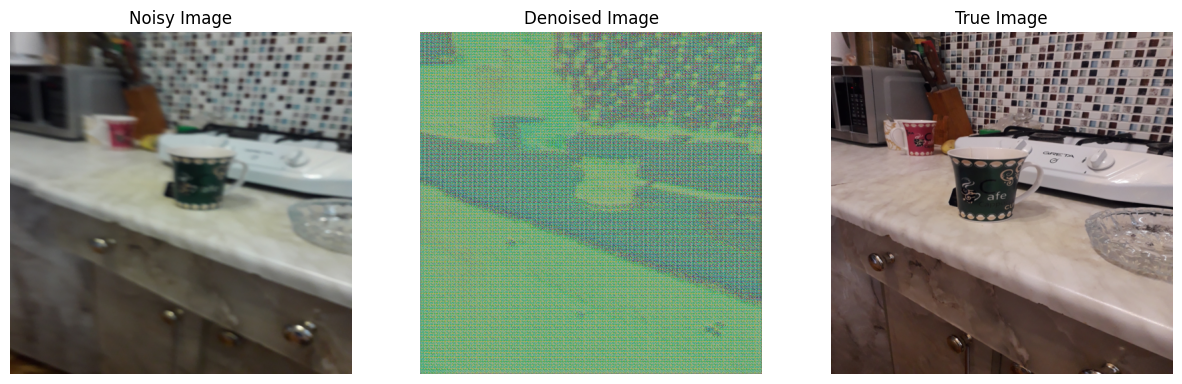

Noisy PSNR: 28.29
Noisy SSIM: 0.3969
Gen PSNR: 28.365397566113156
Gen SSIM: 0.06167371586570116


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
## Display images and test scores
gt_images, noisy_images = load_image_pairs("/content/blur_dataset_scaled")
print(gt_images[0:10])
print(noisy_images[0:10])
dataset = ImagePairDataset(gt_images, noisy_images, preprocess_transform)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

gen = Generator()
gen.apply(weights_init)
# gen.load_state_dict(torch.load("/content/generator.pth", map_location=device))
gen.eval()
for gt, noisy in dataloader:
  for i in range(gt.size(0)):
    gt_image = gt[i]
    noisy_image = noisy[i]
    gt = postprocess_tensor(gt_image)
    # Generate denoised image
    gen_image = gen(noisy_image.unsqueeze(0))
    gen_image = postprocess_tensor(gen_image)
    noisy = postprocess_tensor(noisy_image)
    # Display the images
    display_images_and_calc_metrics(noisy, gen_image, gt)
    break
  break


In [36]:
def evaluate_model(model, test_loader, device):
  psnr_input = []
  ssim_input = []
  psnr_output = []
  ssim_output = []
  # Evaluate the model on the test set
  for i, (gt, noisy) in enumerate(test_loader):
    model.eval()
    with torch.no_grad():
      gt_image = gt
      noisy_image = noisy.to(device)
      gt_img = postprocess_tensor(gt_image)
      # Generate denoised image
      gen_image = model(noisy_image)
      gen_img = postprocess_tensor(gen_image.cpu())
      noisy_img = postprocess_tensor(noisy_image.cpu())
      # Display the images
      psnr_in, ssim_in, psnr_out, ssim_out = display_images_and_calc_metrics(noisy_img, gen_img, gt_img, display=False)
      # append evaluation metrics
      psnr_input.append(psnr_in)
      ssim_input.append(ssim_in)
      psnr_output.append(psnr_out)
      ssim_output.append(ssim_out)

      if i % 5 == 0:
        print(f'Batch {i}/{len(test_loader)}')
  # average the lists
  print(len(psnr_input))
  avg_psnr_input = sum(psnr_input) / len(psnr_input)
  avg_ssim_input = sum(ssim_input) / len(ssim_input)
  avg_psnr_output = sum(psnr_output) / len(psnr_output)
  avg_ssim_output = sum(ssim_output) / len(ssim_output)

  return avg_psnr_input, avg_ssim_input, avg_psnr_output, avg_ssim_output


In [38]:
!cp /content/drive/MyDrive/gen_30_trained_ssid.pth /content/generator_sidd.pth

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# Load data
data_folder = "/content/SIDD_Small_sRGB_Only/Data"
gt_images, noisy_images = load_image_pairs(data_folder, dataset="sidd")

# split to train and val
noisy_train_images, noisy_test_images = train_test_split(noisy_images, test_size=0.2, random_state=42)
gt_train_images, gt_test_images = train_test_split(gt_images, test_size=0.2, random_state=42)
print(f'Number of training images: {len(gt_train_images)}')
print(f'Number of test images: {len(noisy_test_images)}')

# Create dataset
test_set = ImagePairDataset(gt_test_images, noisy_test_images, transform=preprocess_transform)

# Create data loaders
test_loader = DataLoader(test_set, batch_size=1, shuffle=False)

#load model
model = Generator().to(device)
saved_path = "/content/generator_sidd.pth"
model.load_state_dict(torch.load(saved_path, map_location=device))
model.eval()

# Evaluate
avg_psnr_input, avg_ssim_input, avg_psnr_output, avg_ssim_output = evaluate_model(model, test_loader, device)
print(f"Average PSNR input: {avg_psnr_input:.2f}")
print(f"Average SSIM input: {avg_ssim_input:.4f}")
print(f"Average PSNR output: {avg_psnr_output:.2f}")
print(f"Average SSIM output: {avg_ssim_output:.4f}")

cuda
Number of training images: 128
Number of test images: 32
Batch 0/32
Batch 5/32
Batch 10/32
Batch 15/32
Batch 20/32
Batch 25/32
Batch 30/32
32
Average PSNR input: 39.09
Average SSIM input: 0.9296
Average PSNR output: 28.36
Average SSIM output: 0.5036


In [ ]:
# Function to train the SRGAN model
def train_denoising_gan(generator, discriminator, train_loader, val_loader, criterion_g, criterion_d, optimizer_g, optimizer_d, num_epochs=10, device='cuda'):
    for epoch in range(num_epochs):
        generator.train()
        discriminator.train()

        running_loss_g = 0.0
        running_loss_d = 0.0

        for i, (gt_image, noisy_image) in enumerate(train_loader):
            gt_image = gt_image.to(device)
            noisy_image = noisy_image.to(device)

            # Discriminator Training
            optimizer_d.zero_grad()

            gen_image = generator(noisy_image)

            real_output = discriminator(gt_image)
            fake_output = discriminator(gen_image.detach())  # Detach for the discriminator training step
            # print(real_output.shape, fake_output.shape)
            real_labels = torch.ones_like(real_output).to(device)
            fake_labels = torch.zeros_like(fake_output).to(device)
            # Calculate the loss for real and fake images
            loss_d_real = criterion_d(real_output, real_labels)
            loss_d_fake = criterion_d(fake_output, fake_labels)
            # Average the loss over all elements of the output tensor
            loss_d = (loss_d_real + loss_d_fake) / 2
            loss_d.backward()
            optimizer_d.step()

            # Generator Training
            optimizer_g.zero_grad()


            gen_output = discriminator(gen_image)
            # Calculate the loss for generator based on discriminator's output
            loss_g_adv = criterion_g(gen_output, real_labels)  # Adversarial loss

            loss_g = loss_g_adv + criterion_g(gen_image, gt_image)
            loss_g.backward()
            optimizer_g.step()

            running_loss_g += loss_g.item() * gt_image.size(0)
            running_loss_d += loss_d.item() * gt_image.size(0)

            if i % 2 == 0:
                print(f'Epoch {epoch+1}/{num_epochs}, Batch {i}/{len(train_loader)}, Loss D: {loss_d.item():.4f}, Loss G: {loss_g.item():.4f}')

        epoch_loss_g = running_loss_g / len(train_loader.dataset)
        epoch_loss_d = running_loss_d / len(train_loader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs}, Generator Loss: {epoch_loss_g:.4f}, Discriminator Loss: {epoch_loss_d:.4f}')

        if (epoch % 5 == 0) and (epoch > 5):
          torch.save(generator.state_dict(), f'generator_{epoch}.pth')
          torch.save(discriminator.state_dict(), f'discriminator_{epoch}.pth')
          print(f'Model saved to generator_{epoch}.pth and discriminator_{epoch}.pth')

        # Validation
        generator.eval()
        discriminator.eval()
        eval_metrics = []
        with torch.no_grad():
          for n, (gt_images, noisy_images) in enumerate(val_loader):
            for i in range(gt_images.size(0)):
              gt_imag = gt_images[i]
              noisy_img = noisy_images[i].to(device)
              gt = postprocess_tensor(gt_imag)
              # Generate denoised image
              gen_img = generator(noisy_img.unsqueeze(0))
              gen_image = postprocess_tensor(gen_img.cpu())
              noisy = postprocess_tensor(noisy_img.cpu())
              # Display the images
              display = False
              if n % 8 == 0:
                display = True
              metrics = display_images_and_calc_metrics(noisy, gen_image, gt, display=display)
              eval_metrics.append(metrics)

    return generator, discriminator, eval_metrics

In [ ]:
# Main function to load data, train model, and compute metrics
def main(train_folder, num_epochs=5, device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') ):

    print(f'Using device: {device}')

    # Load image pairs
    gt_images, noisy_images = load_image_pairs(train_folder)

    # split to train and val
    noisy_train_images, noisy_val_images = train_test_split(noisy_images, test_size=0.2, random_state=42)
    gt_train_images, gt_val_images = train_test_split(gt_images, test_size=0.2, random_state=42)
    print(f'Number of training images: {len(gt_train_images)}')
    print(f'Number of validation images: {len(noisy_val_images)}')

    # Create dataset
    train_set = ImagePairDataset(gt_train_images, noisy_train_images, transform=preprocess_transform)
    val_set = ImagePairDataset(gt_val_images, noisy_val_images, transform=preprocess_transform)

    # Create data loaders
    train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=8, shuffle=False)

    # Initialize model
    gen = Generator().to(device)
    disc = Discriminator().to(device)
    gen.apply(weights_init)
    disc.apply(weights_init)
    # print(gen)
    # print(disc)

    # Define loss function and optimizer
    criterion_g = nn.MSELoss() # minimize difference between generated and real images
    criterion_d = nn.BCEWithLogitsLoss()  # For discriminator, to classify between real and fake images

    # Optimizers for generator and discriminator
    optimizer_g = optim.Adam(gen.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizer_d = optim.Adam(disc.parameters(), lr=0.0002, betas=(0.5, 0.999))

    # Train the model
    generator, discriminator, eval_metrics = train_denoising_gan(gen, disc, train_loader, val_loader, criterion_g, criterion_d, optimizer_g, optimizer_d, num_epochs, device=device)

    # Save model
    torch.save(generator.state_dict(), 'generator.pth')
    print(f'Model saved to generator.pth')
    torch.save(discriminator.state_dict(), 'discriminator.pth')
    print(f'Model saved to discriminator.pth')

    eval_metrics = np.array(eval_metrics)
    print(f'Mean PSNR Input: {np.mean(eval_metrics[:, 0]):.4f}')
    print(f'Mean SSIM Input: {np.mean(eval_metrics[:, 1]):.4f}')
    print(f'Mean PSNR Gen: {np.mean(eval_metrics[:, 2]):.4f}')
    print(f'Mean RMSE Gen: {np.mean(eval_metrics[:, 3]):.4f}')

    # save metric array to csv
    np.savetxt('metrics.csv', eval_metrics, delimiter=',')
    print(f'Metrics saved to metrics.csv')



In [ ]:
# Define variables
train_folder = '/content/blur_dataset_scaled'  # Path to the folder containing image pairs
num_epochs = 50  # Number of epochs to train the model

# Call the main function
main(train_folder, num_epochs)

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
!cp -r /content/generator.pth /content/drive/MyDrive/gen_50_trained_blur.pth

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
